[Paper](https://kanezaki.github.io/pytorch-unsupervised-segmentation/ICASSP2018_kanezaki.pdf)

#### Download a sample

In [4]:
! wget "https://github.com/Jimut123/srgan/raw/master/RESULTS/inp1.png"

--2021-02-03 16:18:53--  https://github.com/Jimut123/srgan/raw/master/RESULTS/inp1.png
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Jimut123/srgan/master/RESULTS/inp1.png [following]
--2021-02-03 16:18:53--  https://raw.githubusercontent.com/Jimut123/srgan/master/RESULTS/inp1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9781716 (9.3M) [application/octet-stream]
Saving to: ‘inp1.png’

inp1.png            100%[===================>]   9.33M  --.-KB/s    in 0.1s    

2021-02-03 16:18:54 (70.6 MB/s) - ‘inp1.png’ saved [9781716/9781716]



#### Reshape for good

In [19]:
def reshape_image(img_name):

  img = cv2.imread(img_name, cv2.IMREAD_UNCHANGED)
  thumb_name, exten = img_name.split('.')
  thumb_name = thumb_name + "_test"
  print('Original Dimensions : ',img.shape)
    
  scale_percent = 5 # percent of original size
  print("RESCALING TO :=> ", scale_percent)
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

  print('Resized Dimensions : ',resized.shape)
  cv2.imwrite(str(thumb_name+"."+exten),resized)

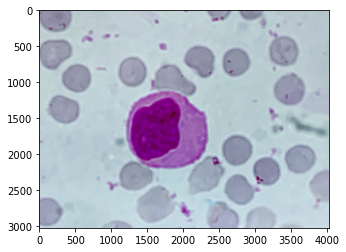

In [39]:
import matplotlib.pyplot as plt
import cv2
import imageio
img = cv2.imread('inp1.png')
plt.imshow(img)

In [21]:
reshape_image('inp1.png')

Original Dimensions :  (3024, 4032, 4)
RESCALING TO :=>  5
Resized Dimensions :  (151, 201, 4)


In [22]:
#! python demo.py --input inp1_test.png

#### Store into a separate folder

In [28]:
! mkdir images_gen

#### Tune Hyper Params

In [95]:
#PyTorch Unsupervised Segmentation
nChannel = 10                                       #number of channels
maxIter = 400                                        #number of maximum iterations
minLabels = 3                                         #minimum number of labels
lr = 0.01                                              #learning rate
nConv = 5                                             #number of convolutional layers
num_superpixels = 10000                               #number of superpixels
compactness = 100                                     #compactness of superpixels
visualize = 1                                         # or 0 visualization flag
input =  'inp1_test.png'                              #input image file name'


#### Segmentation by Backprop

In [91]:
# python demo.py --input images/101027.jpg
# https://github.com/kanezaki/pytorch-unsupervised-segmentation

#from __future__ import print_function

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import sys
import numpy as np
from skimage import segmentation
import torch.nn.init

use_cuda = torch.cuda.is_available()

# CNN model
class MyNet(nn.Module):
    def __init__(self,input_dim):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, nChannel, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(nChannel)
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        for i in range(nConv-1):
            self.conv2.append( nn.Conv2d(nChannel, nChannel, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(nChannel) )
        self.conv3 = nn.Conv2d(nChannel, nChannel, kernel_size=1, stride=1, padding=0 )
        self.bn3 = nn.BatchNorm2d(nChannel)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(nConv-1):
            x = self.conv2[i](x)
            x = F.relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

# load image
im = cv2.imread(input)
data = torch.from_numpy( np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.]) )
if use_cuda:
    data = data.cuda()
data = Variable(data)

# slic
labels = segmentation.slic(im, compactness=compactness, n_segments=num_superpixels)
labels = labels.reshape(im.shape[0]*im.shape[1])
u_labels = np.unique(labels)
l_inds = []
for i in range(len(u_labels)):
    l_inds.append( np.where( labels == u_labels[ i ] )[ 0 ] )

ko = 0
frames_list = ['inp1_test.png']*5
# train
model = MyNet( data.size(1) )
if use_cuda:
    model.cuda()
model.train()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
label_colours = np.random.randint(255,size=(100,3))
vid_fr_no = 1
for batch_idx in range(maxIter):
    # forwarding
    optimizer.zero_grad()
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, nChannel )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    nLabels = len(np.unique(im_target))
    vid_fr_no += 1
    if visualize:
        im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
        im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
        if vid_fr_no % 5 ==0:
          cv2.imwrite( "images_gen/output_{}.png".format(vid_fr_no), im_target_rgb )
          frames_list.append("images_gen/output_{}.png".format(vid_fr_no))
        #cv2.imshow( "output", im_target_rgb )
        #cv2.waitKey(10)

    # superpixel refinement
    # TODO: use Torch Variable instead of numpy for faster calculation
    for i in range(len(l_inds)):
        labels_per_sp = im_target[ l_inds[ i ] ]
        u_labels_per_sp = np.unique( labels_per_sp )
        hist = np.zeros( len(u_labels_per_sp) )
        for j in range(len(hist)):
            hist[ j ] = len( np.where( labels_per_sp == u_labels_per_sp[ j ] )[ 0 ] )
        im_target[ l_inds[ i ] ] = u_labels_per_sp[ np.argmax( hist ) ]
    target = torch.from_numpy( im_target )
    if use_cuda:
        target = target.cuda()
    target = Variable( target )
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

    #print (batch_idx, '/', maxIter, ':', nLabels, loss.data[0])
    ko += 1
    if ko % 100 == 0:
      print (batch_idx, '/', maxIter, ':', nLabels, loss.item())

    if nLabels <= minLabels:
        print ("nLabels", nLabels, "reached minLabels", minLabels, ".")
        break

# save output image
if not visualize:
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, nChannel )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
    im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
cv2.imwrite( "output.png", im_target_rgb )

99 / 400 : 9 0.32772591710090637
199 / 400 : 9 0.20414851605892181
299 / 400 : 8 0.12857215106487274
399 / 400 : 5 0.08050257712602615


True

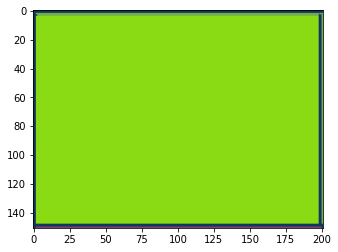

In [92]:
output = cv2.imread('output.png')
plt.imshow(output)

#### Make the video

In [93]:
out_file = 'video.gif'

with imageio.get_writer(out_file, mode='I') as writer:
    #filenames = glob.glob('images_gen/*.png')
    #filenames = sorted(filenames)
    
    last = -1
    for i, filename in enumerate(frames_list):
        frame = i
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

    import IPython
    if IPython.version_info > (6,2,0,''):
        display.Image(filename=out_file)

#### Show the video

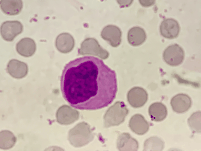

In [94]:
from IPython.display import HTML
from IPython.display import Image
with open('video.gif','rb') as f:
    display(Image(data=f.read(), format='png'))
